# Data Modeling

In this notebook, I'm going to use the smoke estimator and AQI data from Part 1, with the crime data described in Part 2, to build models and see how they perform.

## Preliminary and Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

/usr/local/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import Data
### Crime Data

In [2]:
df_crime = pd.read_csv("nibrs_crime_data.csv")
df_crime_year = df_crime.groupby('data_year').sum('offense_count').reset_index()
df_crime_year.head()

,data_year,offense_count
0,2000,44
1,2001,39
2,2002,33
3,2003,42
4,2004,35


### Population

In [3]:
df_population = pd.read_csv("population_cedar_city.csv").rename(columns={'date':'data_year', 'Cedar City Count_Person':'population'})
df_population.head()

,data_year,population
0,1990,13530
1,1991,13578
2,1992,13915
3,1993,14356
4,1994,16290


### Crime Rate

In [4]:
df_crime_rate = pd.merge(df_crime_year, df_population, on='data_year')
df_crime_rate['crime_rate'] = df_crime_rate['offense_count'] / df_crime_rate['population']
df_crime_rate.head()

,data_year,offense_count,population,crime_rate
0,2000,44,20809,0.002114
1,2001,39,21268,0.001834
2,2002,33,21852,0.001510
3,2003,42,22303,0.001883
4,2004,35,22940,0.001526


### Smoke Estimator

In [5]:
df_estimator = pd.read_csv("df_attributes_estimator.csv")
df_estimator = df_estimator[df_estimator['Scaled_Smoke_Estimate'] > 15]
df_estimator_year = df_estimator.groupby('Fire_Year')['Scaled_Smoke_Estimate'].mean().reset_index()
df_estimator_year.head()

,Fire_Year,Scaled_Smoke_Estimate
0,1964,19.520710
1,1965,25.564820
2,1966,29.598843
3,1967,17.157263
4,1968,15.765356


In [6]:
df_estimator_year['Fire_Year'].dtype

dtype('int64')

### AQI Data

In [7]:
df_aqi = pd.read_csv('df_average_aqi.csv')
df_aqi.head()

,year,aqi
0,1975,95.000000
1,1976,109.720339
2,1977,25.926773
3,1978,34.164474
4,1979,4.282486


In [8]:
df_param_aqi = pd.read_csv('df_average_param_aqi.csv')
df_param_aqi.head()

,year,parameter,aqi
0,1975,Sulfur dioxide,95.000000
1,1976,Sulfur dioxide,109.720339
2,1977,Nitrogen dioxide (NO2),6.480769
3,1977,Sulfur dioxide,36.722420
4,1978,Nitrogen dioxide (NO2),6.910448


## Visualization

In [10]:
df_param_plot = pd.merge(df_crime_rate, df_estimator_year, 
                   how="outer",
                   left_on="data_year", 
                   right_on="Fire_Year")
df_param_plot['Fire_Year'] = df_param_plot['Fire_Year'].fillna(df_param_plot['data_year'])
df_param_plot = df_param_plot.sort_values(by=['Fire_Year']).drop(columns=['data_year'])
df_param_plot = pd.merge(df_param_plot, df_param_aqi, how='left', left_on='Fire_Year', right_on='year')
df_param_plot.head()

,offense_count,population,crime_rate,Fire_Year,Scaled_Smoke_Estimate,year,parameter,aqi
0,NaN,NaN,NaN,1964.0,19.520710,NaN,NaN,NaN
1,NaN,NaN,NaN,1965.0,25.564820,NaN,NaN,NaN
2,NaN,NaN,NaN,1966.0,29.598843,NaN,NaN,NaN
3,NaN,NaN,NaN,1967.0,17.157263,NaN,NaN,NaN
4,NaN,NaN,NaN,1968.0,15.765356,NaN,NaN,NaN


In [12]:
df_param_model = df_param_plot.dropna().drop(columns=['Fire_Year'])
df_param_model = df_param_model[df_param_model['parameter'].isin(['Ozone', 'PM2.5 - Local Conditions'])]
df_param_model.head()

,offense_count,population,crime_rate,Scaled_Smoke_Estimate,year,parameter,aqi
55,35.0,22940.0,0.001526,25.489111,2004.0,Ozone,63.018416
58,41.0,24821.0,0.001652,41.584099,2005.0,Ozone,67.517056
61,16.0,26626.0,0.000601,40.290522,2006.0,Ozone,61.774725
68,55.0,28611.0,0.001922,31.726681,2008.0,Ozone,58.447761
82,10.0,29154.0,0.000343,44.344453,2011.0,Ozone,57.742829


In [13]:
pivot_df = df_param_model.pivot_table(index=['year', 'offense_count', 'Scaled_Smoke_Estimate'], columns='parameter', values='aqi')

# Rename columns if desired
pivot_df.columns = [f'{col}_aqi' for col in pivot_df.columns]

# Reset index if necessary
pivot_df = pivot_df.reset_index()

pivot_df_all = pd.merge(pivot_df, df_crime_rate, left_on='year', right_on='data_year')
pivot_df_all.head()

,year,offense_count_x,Scaled_Smoke_Estimate,Ozone_aqi,PM2.5 - Local Conditions_aqi,data_year,offense_count_y,population,crime_rate
0,2004.0,35.0,25.489111,63.018416,NaN,2004,35,22940,0.001526
1,2005.0,41.0,41.584099,67.517056,NaN,2005,41,24821,0.001652
2,2006.0,16.0,40.290522,61.774725,NaN,2006,16,26626,0.000601
3,2008.0,55.0,31.726681,58.447761,NaN,2008,55,28611,0.001922
4,2011.0,10.0,44.344453,57.742829,22.916667,2011,10,29154,0.000343


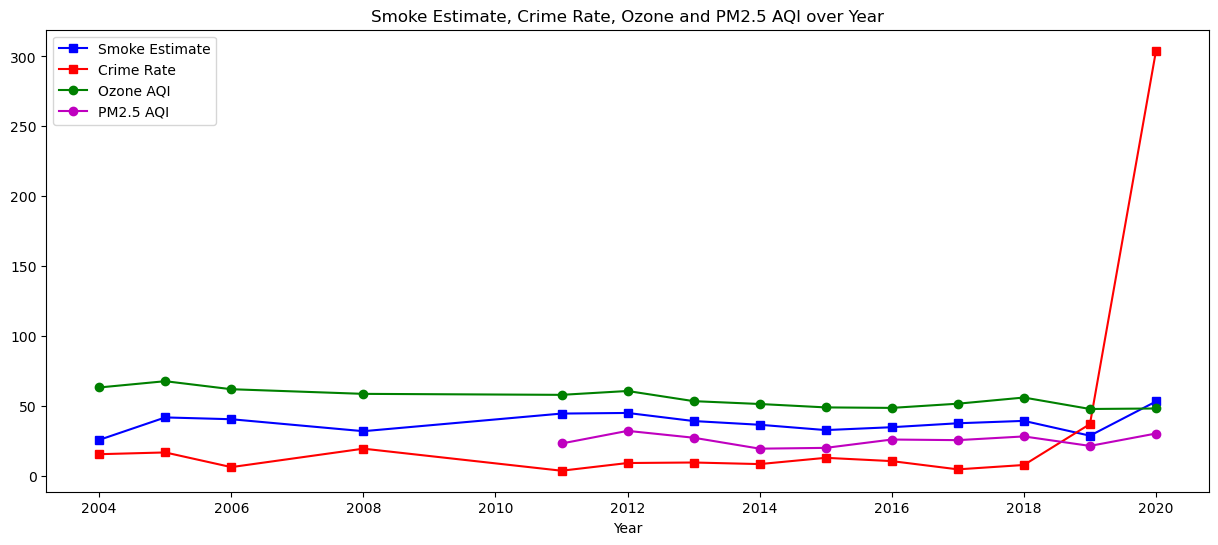

In [14]:
fig, ax1 = plt.subplots(figsize=(15, 6))
x = pivot_df_all['data_year']
y_smoke = pivot_df_all['Scaled_Smoke_Estimate']
y_crime_rate = pivot_df_all['crime_rate'] * 10000
y_ozone_aqi = pivot_df_all['Ozone_aqi']
y_pm25_aqi = pivot_df_all['PM2.5 - Local Conditions_aqi']

ax1.plot(x, y_smoke, 'b-', label='Smoke Estimate', marker='s')
ax1.plot(x, y_crime_rate, 'r-', label='Crime Rate', marker='s')
ax1.plot(x, y_ozone_aqi, 'g-', label='Ozone AQI', marker='o')
ax1.plot(x, y_pm25_aqi, 'm-', label='PM2.5 AQI', marker='o')

ax1.set_xlabel('Year')
ax1.set_title('Smoke Estimate, Crime Rate, Ozone and PM2.5 AQI over Year')
ax1.legend()

plt.show()

## Linear Model

In [20]:
# Preparing the data
# Linear Model
pivot_df_all_dropna = pivot_df_all.dropna()

# X = pivot_df_all_dropna[['Scaled_Smoke_Estimate', 'Ozone_aqi', 'PM2.5 - Local Conditions_aqi', 'year']]
X = pivot_df_all_dropna[['Scaled_Smoke_Estimate', 'Ozone_aqi', 'PM2.5 - Local Conditions_aqi']]
y = pivot_df_all_dropna['crime_rate']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
sumvalue = np.sum(y_test)
mape = np.sum(np.abs((y_test - y_pred))) / sumvalue*100
acc = 100-mape
print('Accuracy:', round(acc,2), '%')

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Accuracy: -111.23 %
Mean Squared Error: 3.596862132266053e-05
R² Score: -18.012340571047492


## Random Forest Model

The following lag function produces lag for each variable in my dataset for forecasting.

In [16]:
def tabelLag(df, max_lag, min_lag=0, seperator="_"):
    values = []
    for i in range(min_lag, max_lag+1):
        values.append(df.shift(i).copy())
        values[-1].columns = [c + seperator + str(i) for c in df.columns]
    return pd.concat(values, axis=1)

In [21]:
X_lag = tabelLag(X[['Scaled_Smoke_Estimate', 'Ozone_aqi', 'PM2.5 - Local Conditions_aqi']], 1)
X_lag.head()

,Scaled_Smoke_Estimate_0,Ozone_aqi_0,PM2.5 - Local Conditions_aqi_0,Scaled_Smoke_Estimate_1,Ozone_aqi_1,PM2.5 - Local Conditions_aqi_1
4,44.344453,57.742829,22.916667,NaN,NaN,NaN
5,44.784456,60.502947,31.962963,44.344453,57.742829,22.916667
6,38.994950,53.236413,27.048387,44.784456,60.502947,31.962963
7,36.321152,51.194624,19.215686,38.994950,53.236413,27.048387
8,32.521391,48.753623,19.790393,36.321152,51.194624,19.215686


Since the data is time series, it would be better to split the train and test set by time. The following code takes the most recent 4 years as test set and use the remaining data as train set.

In [18]:
test_length = 4
end_point = len(X)
x = end_point - test_length
X_train = X_lag[1:].loc[:x-1, :]
X_test = X_lag[1:].loc[x:, :]
y_train = y[1:].loc[:x-1]
y_test = y[1:].loc[x:]

rf1 = RandomForestRegressor().fit(X_train, y_train)
y_pred = rf1.predict(X_test)

In [19]:
sumvalue = np.sum(y_test)
mape = np.sum(np.abs((y_test - y_pred))) / sumvalue*100
acc = 100-mape
print('Accuracy:', round(acc,2), '%.')

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

Accuracy: 14.78 %.
Mean Squared Error: 0.0001099012075736458
R² Score: -0.1726086992956033
